In [8]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import medmnist

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [4]:
from src.models import *
from src.functions import *
from src.data import *
from src.rvae import *
from src.trainer import *
from src.classifier import *
from src.steps import *
from src.similarity import *

In [5]:
%load_ext autoreload
%autoreload 3

In [11]:
path_trainset = medmnist.PathMNIST(root='data/MedMNIST/', split='train', download=True)
path_testset = medmnist.PathMNIST(root='data/MedMNIST/', split='test', download=True)

  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: data/MedMNIST/pathmnist.npz


In [12]:
retina_trainset = medmnist.RetinaMNIST(root='data/MedMNIST/', split='train', download=True)
retina_testset = medmnist.RetinaMNIST(root='data/MedMNIST/', split='test', download=True)

  0%|          | 0/3291041 [00:00<?, ?it/s]

Using downloaded and verified file: data/MedMNIST/retinamnist.npz


In [13]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

True
1.11.0+cu113
4


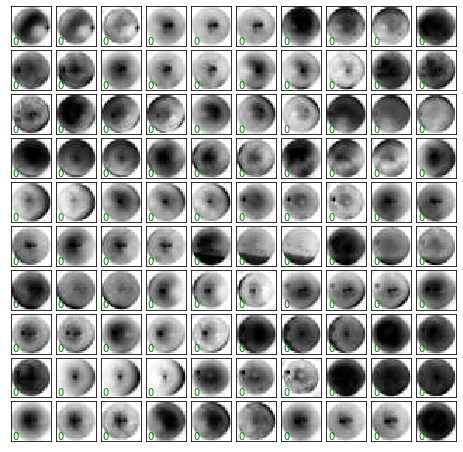

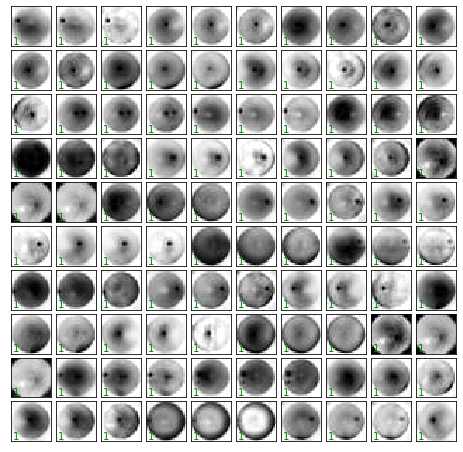

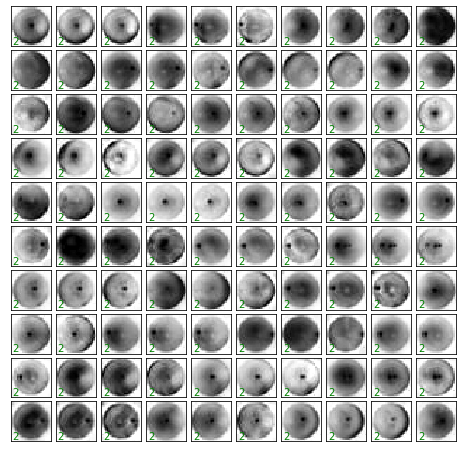

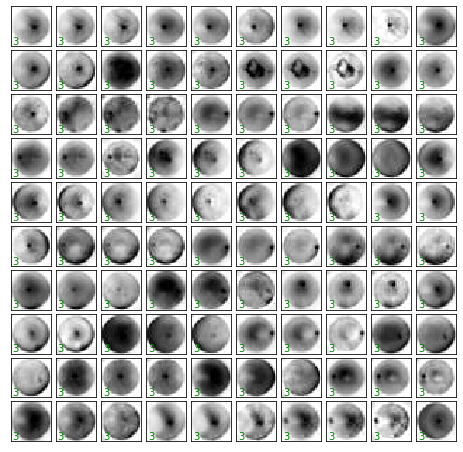

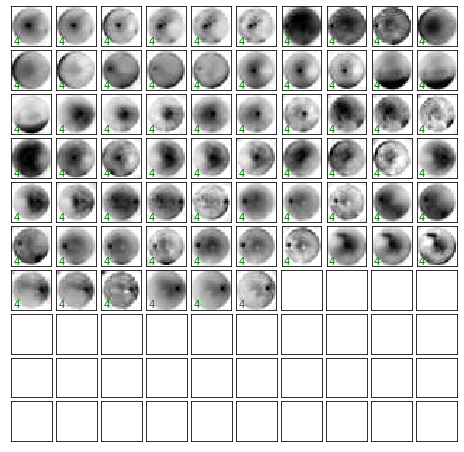

In [25]:
for i in range(5):
    train_data, train_labels, angles, translations = get_mnist_data(
        retina_trainset, 
        digits = [i],
        coord = 0
        )

    fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for ax, im, lbl in zip(axes.flat, train_data, train_labels):
        ax.imshow(im, cmap='binary', interpolation='nearest')
        ax.text(0.05, 0.05, str(lbl.item()),
                transform=ax.transAxes, color='green')

In [22]:
print(path_trainset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: data/MedMNIST/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into traini

In [23]:
print(retina_trainset)

Dataset RetinaMNIST (retinamnist)
    Number of datapoints: 1080
    Root location: data/MedMNIST/
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
